# Reinforcement learning (RL)

It encompasses a diverse set of algorithmic approaches that enable an agent to learn optimal behavior through trial-and-error interactions with an environment. These approaches can be broadly categorized based on how the agent represents and learns its policy and/or value function. Three prominent approaches include Value-Based Methods, Policy-Based Methods, and Actor-Critic Methods.



**1. Value-Based Methods:**

Value-based methods primarily focus on learning an optimal *value function*, which estimates the expected return (cumulative future reward) for being in a particular state or taking a specific action in a given state. The policy, which dictates the agent's behavior, is then derived implicitly by selecting the action that maximizes this value function. A quintessential example of a value-based method is Q-learning.

In Q-learning, the agent learns the Q-value, $Q(s, a)$, which represents the expected return of taking action $a$ in state $s$ and following an optimal policy thereafter. The Q-value is updated iteratively based on the Bellman optimality equation:

$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

where $s$ is the current state, $a$ is the action taken, $r$ is the immediate reward, $s'$ is the next state, $\gamma$ is the discount factor, $\alpha$ is the learning rate, and $a'$ represents all possible actions in the next state. Once the Q-values have converged (or after sufficient training), the optimal policy $\pi^*(s)$ for a given state $s$ is to select the action that yields the highest Q-value:

$$\pi^*(s) = \arg\max_{a} Q(s, a)$$

Value-based methods are particularly effective in discrete action spaces and can converge to an optimal policy under certain conditions. However, they can struggle in continuous action spaces as finding the action that maximizes the Q-value becomes an optimization problem itself.

In [25]:
import numpy as np
import random

# Simple Grid World Environment
class GridWorld:
    def __init__(self, size=4, goal=(3, 3)):
        self.size = size
        self.goal = goal
        self.agent_pos = (0, 0)
        self.actions = ['N', 'S', 'E', 'W']
        self.state_space = [(r, c) for r in range(size) for c in range(size)]

    def is_valid(self, pos):
        return 0 <= pos[0] < self.size and 0 <= pos[1] < self.size

    def step(self, action):
        r, c = self.agent_pos
        if action == 'N': r -= 1
        elif action == 'S': r += 1
        elif action == 'E': c += 1
        elif action == 'W': c -= 1
        next_pos = (r, c)
        if not self.is_valid(next_pos):
            return self.agent_pos, -1, False # Stay in place with penalty
        self.agent_pos = next_pos
        reward = 1 if self.agent_pos == self.goal else -0.1
        done = self.agent_pos == self.goal
        return self.agent_pos, reward, done

    def reset(self):
        self.agent_pos = (0, 0)
        return self.agent_pos

# Q-learning implementation
def q_learning(env, alpha=0.1, gamma=0.9, epsilon=0.1, num_episodes=1000):
    q_table = {state: {action: 0 for action in env.actions} for state in env.state_space}
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.actions) # Explore
            else:
                action = max(env.actions, key=lambda a: q_table[state][a]) # Exploit
            next_state, reward, done = env.step(action)
            best_next_q = max(q_table[next_state].values())
            q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * best_next_q - q_table[state][action])
            state = next_state
    policy = {state: max(env.actions, key=lambda a: q_table[state][a]) for state in env.state_space}
    return q_table, policy

env = GridWorld()
q_table, policy = q_learning(env)
print("Learned Q-table:")
for state, actions in q_table.items():
    print(f"{state}: {actions}")
print("\nLearned Policy:")
for state, action in policy.items():
    print(f"{state}: {action}")

Learned Q-table:
(0, 0): {'N': -0.7841073589103553, 'S': 0.1809799999999987, 'E': 0.13507690256004654, 'W': -0.804764495018773}
(0, 1): {'N': -0.2989426196133611, 'S': 0.31132948915884595, 'E': -0.11777611089075064, 'W': -0.1135813373550582}
(0, 2): {'N': -0.27802070792821, 'S': 0.4119600219739493, 'E': -0.07475264062514886, 'W': -0.08177155387297985}
(0, 3): {'N': -0.1, 'S': 0.5877157345721038, 'E': -0.2934939713197022, 'W': -0.04312073745100001}
(1, 0): {'N': 0.044080033732058634, 'S': 0.037398874745420876, 'E': 0.3121999999999987, 'W': -0.6857989001186507}
(1, 1): {'N': 0.15933432370492875, 'S': 0.27871897481918345, 'E': 0.45799999999999874, 'W': 0.15688682061153494}
(1, 2): {'N': 0.17423785433385322, 'S': 0.5514589563956429, 'E': 0.6199999999999988, 'W': 0.2895580123404153}
(1, 3): {'N': 0.3425893116727812, 'S': 0.7999999999999992, 'E': -0.2512248253367405, 'W': 0.37913425297611125}
(2, 0): {'N': -0.0789370878465394, 'S': -0.0739343484901, 'E': 0.32029583531956135, 'W': -0.35517252

**2. Policy-Based Methods:**

In contrast to value-based methods, policy-based methods directly learn a parameterized policy $\pi_\theta(a|s)$ that maps states to probabilities of selecting each action. The goal is to find the policy parameters $\theta$ that maximize the expected return. These methods do not explicitly learn a value function, although a value function might be used to evaluate or guide policy updates.

A common technique in policy-based methods is policy gradient, where the policy parameters are updated in the direction of the gradient of an objective function that measures the policy's performance. A popular policy gradient algorithm is REINFORCE (Reinforcement with Credit Assignment). The policy parameter update in REINFORCE is typically of the form:

$$\theta \leftarrow \theta + \alpha G_t \nabla_\theta \log \pi_\theta(A_t|S_t)$$

where $\alpha$ is the learning rate, $G_t$ is the return (cumulative reward) from time $t$, $\pi_\theta(A_t|S_t)$ is the probability of taking action $A_t$ in state $S_t$ under the current policy, and $\nabla_\theta \log \pi_\theta(A_t|S_t)$ is the gradient of the logarithm of the policy with respect to the parameters $\theta$. The term $\log \pi_\theta(A_t|S_t)$ encourages actions that lead to higher returns to be chosen more often in the future.

Policy-based methods can handle continuous action spaces and stochastic policies naturally. They can also learn optimal policies in scenarios where the value function might be complex or multi-modal. However, they can suffer from high variance in gradient estimates and might take longer to converge compared to value-based methods.



In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple

# Simple Environment (Bernoulli Bandit)
class BernoulliBandit:
    def __init__(self, probs):
        self.probs = probs
        self.num_arms = len(probs)

    def step(self, action):
        reward = 1 if random.random() < self.probs[action] else 0
        return reward

# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        return F.softmax(self.fc(x), dim=0)

# Policy-based method with reinforce implementation
def reinforce(env, policy_network, optimizer, gamma=0.99, num_episodes=1000):
    SavedAction = namedtuple('SavedAction', ['log_prob', 'reward'])
    policy_history = []
    rewards_history = []

    for episode in range(num_episodes):
        state = torch.tensor([0.0]) # Simple state for bandit
        episode_rewards = []
        log_probs = []

        for t in range(10): # Fixed episode length
            probs = policy_network(state)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            policy_history.append(SavedAction(log_prob, None))
            reward = env.step(action.item())
            episode_rewards.append(reward)

        rewards_history.append(sum(episode_rewards))

        # Calculate returns
        returns = []
        R = 0
        for r in reversed(episode_rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9) # Normalize returns

        # Update policy
        policy_loss = []
        for log_prob, reward in policy_history:
            policy_loss.append((-log_prob * returns[policy_history.index((log_prob, reward))]).unsqueeze(0))
        policy_loss = torch.cat(policy_loss).mean()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        policy_history = []

    return rewards_history

env = BernoulliBandit([0.2, 0.7, 0.4])
policy_network = PolicyNetwork(1, env.num_arms)
optimizer = optim.Adam(policy_network.parameters(), lr=0.01)
rewards = reinforce(env, policy_network, optimizer)
print("Rewards per episode:", rewards[-10:])

Rewards per episode: [4, 6, 5, 7, 6, 8, 5, 7, 7, 7]


**3. Actor-Critic Methods:**

Actor-critic methods combine the strengths of both value-based and policy-based approaches. They typically maintain two separate function approximators:

* **Actor:** Represents the policy $\pi_\theta(a|s)$ and is responsible for selecting actions.
* **Critic:** Represents the value function $V_w(s)$ or the action-value function $Q_w(s, a)$ and is responsible for evaluating the actions taken by the actor.

The critic provides feedback to the actor, guiding the policy updates. For instance, if the critic estimates that an action taken by the actor leads to a higher-than-expected return, the actor's policy is updated to increase the probability of taking that action in similar states.

A common actor-critic algorithm is A2C (Advantage Actor-Critic) and its synchronous variant A3C (Asynchronous Advantage Actor-Critic). The advantage function $A(s, a) = Q(s, a) - V(s)$ (or an estimate thereof) is often used by the critic to provide a more precise signal to the actor, indicating how much better an action is compared to the average value of the state. The actor's policy is then updated using a policy gradient that incorporates the advantage:

$$\theta \leftarrow \theta + \alpha A(s, a) \nabla_\theta \log \pi_\theta(a|s)$$

Actor-critic methods can be more stable and efficient than pure policy-based methods as the critic helps to reduce the variance of policy gradient estimates. They can also handle both continuous and discrete action spaces.



In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Simple Environment (CartPole-v1 from Gym) - Requires installation of gym
# pip install gymnasium
import gymnasium as gym

# Actor Network
class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

# Critic Network
class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Actor-Critic implementation
def a2c(env, actor, critic, actor_optimizer, critic_optimizer, gamma=0.99, num_episodes=500):
    rewards_history = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_rewards = 0
        log_probs = []
        values = []
        rewards = []
        dones = []

        for t in range(10): # Max steps per episode
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = actor(state_tensor)
            value = critic(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            dones.append(done)

            state = next_state
            episode_rewards += reward
            if done:
                break

        rewards_history.append(episode_rewards)

        # Calculate returns and advantages
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).unsqueeze(1)
        values = torch.stack(values)
        advantages = returns - values

        # Actor loss
        actor_loss = (-torch.stack(log_probs) * advantages.detach()).mean()

        # Critic loss
        critic_loss = F.mse_loss(values, returns)

        # Update actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

    return rewards_history

env = gym.make('CartPole-v1')
actor = Actor(env.observation_space.shape[0], env.action_space.n)
critic = Critic(env.observation_space.shape[0])
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.005)
rewards = a2c(env, actor, critic, actor_optimizer, critic_optimizer)
print("Rewards per episode:", rewards[-10:])
env.close()


<ipython-input-27-8cb4a7140b5d>:81: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-27-8cb4a7140b5d>:81: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-27-8cb4a7140b5d>:81: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Rewards per episode: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]


## Case Study

Suppose that you are developing an autonomous robot for a company specialising in warehouse management. The robot's main task is to navigate through various rooms in the warehouse to transport goods, assist in inventory checks, and optimise operations. The warehouse is divided into 12 rooms. Some of these rooms are separated by walls (barriers), represented by dark lines, which block direct access between certain rooms. Other rooms are open and allow the robot to move freely between them.

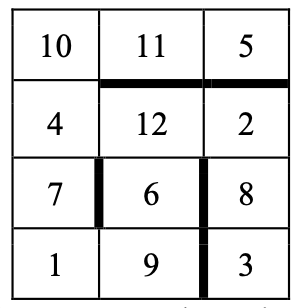

To achieve this, we need to represent all possible transitions between the 12 rooms in the warehouse, as depicted in Figure 1 of the PDF.  A reward table is a mapping that assigns a reward value to each possible transition from one room (state) to another room (state).

An initial reward table, where all state transitions are set to zero, signifies a state where the autonomous robot has no prior knowledge or feedback about the consequences of moving from one room to another.  In essence, every action taken by the robot yields a neutral outcome until it begins to explore the environment and receive feedback.

The structure of the reward table can be implemented using a dictionary in Python. The keys of the dictionary will be tuples representing the transition from one room to another (e.g., (1, 2) for moving from Room 1 to Room 2), and the initial value for all keys will be 0.

It's important to note that the robot's actions are implicit in the state transitions.  For example, if the robot moves from room 1 to room 2, the action is "move to room 2". Therefore, the reward is associated with the transition rather than a separate "action" entity.

Initial Reward Table:
Transition: (1, 2), Reward: 0
Transition: (1, 3), Reward: 0
Transition: (1, 4), Reward: 0
Transition: (1, 5), Reward: 0
Transition: (1, 6), Reward: 0
Transition: (1, 7), Reward: 0
Transition: (1, 8), Reward: 0
Transition: (1, 9), Reward: 0
Transition: (1, 10), Reward: 0
Transition: (1, 11), Reward: 0
Transition: (1, 12), Reward: 0
Transition: (2, 1), Reward: 0
Transition: (2, 3), Reward: 0
Transition: (2, 4), Reward: 0
Transition: (2, 5), Reward: 0
Transition: (2, 6), Reward: 0
Transition: (2, 7), Reward: 0
Transition: (2, 8), Reward: 0
Transition: (2, 9), Reward: 0
Transition: (2, 10), Reward: 0
Transition: (2, 11), Reward: 0
Transition: (2, 12), Reward: 0
Transition: (3, 1), Reward: 0
Transition: (3, 2), Reward: 0
Transition: (3, 4), Reward: 0
Transition: (3, 5), Reward: 0
Transition: (3, 6), Reward: 0
Transition: (3, 7), Reward: 0
Transition: (3, 8), Reward: 0
Transition: (3, 9), Reward: 0
Transition: (3, 10), Reward: 0
Transition: (3, 11), Reward: 0
Transition

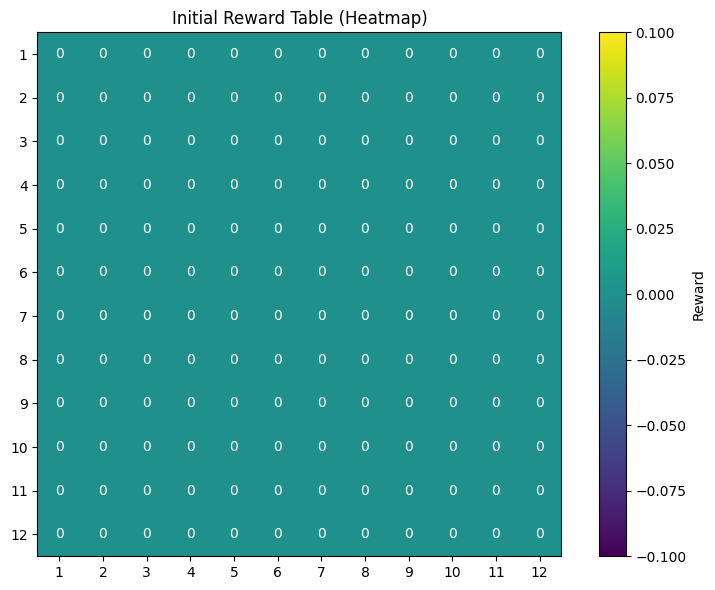

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the rooms
rooms = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Generate all possible transitions between rooms
transitions = [(i, j) for i in rooms for j in rooms if i != j]  # Exclude staying in the same room

# Create the initial reward table (dictionary) with all rewards set to 0
initial_reward_table = {transition: 0 for transition in transitions}

# Display the initial reward table (for smaller environments, can print; for larger, better to visualize)
print("Initial Reward Table:")
for transition, reward in initial_reward_table.items():
    print(f"Transition: {transition}, Reward: {reward}")

# --- Visualization ---

# Create a matrix representation for the heatmap visualization
num_rooms = len(rooms)
reward_matrix = np.zeros((num_rooms, num_rooms))

# Populate the reward matrix from the dictionary
for i in range(num_rooms):
    for j in range(num_rooms):
        if (rooms[i], rooms[j]) in initial_reward_table:
            reward_matrix[i][j] = initial_reward_table[(rooms[i], rooms[j])]

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(reward_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Reward')
plt.title('Initial Reward Table (Heatmap)')

# Set ticks and labels for rooms
plt.xticks(np.arange(num_rooms), labels=rooms)
plt.yticks(np.arange(num_rooms), labels=rooms)

# Add annotations (the reward values) - optional, but makes it clearer
for i in range(num_rooms):
    for j in range(num_rooms):
        plt.text(j, i, int(reward_matrix[i, j]), ha="center", va="center", color="white")

plt.tight_layout()
plt.show()

Say,
*   Room 1 (Start Point): where the robot begins its task. It may be where the robot is loaded with goods or receives instructions to begin its journey.
*   Room 12 (Goal Point/Final Destination): where the robot delivers the items or completes its task. It could be a dispatch area or a storage space for completed orders.
*   Room 2 to Room 11: have specific purposes to support the operations such as:
    * Storage Rooms: To temporarily store goods.
    * Sorting Rooms: Where items are sorted by type or priority.
    * Inventory Rooms: For inventory management and checks.
    * Shipping Rooms: Where items are prepared for dispatch or delivery.

The robot's objective is to navigate through these rooms, avoiding blocked paths created by walls (barriers), and completing its tasks in each room as necessary. The reward-state mapping for the autonomous robot for warehouse operations is listed as follows.
*  30: There is no block path between rooms (i.e., the robot can freely move).
*  -10: There is a blocked path between rooms (i.e., a wall or barrier prevents movement).
*  50: Leads to the goal (i.e., the robot reaches Room 12, completing the task).
*  20: The robot cannot transition to the same room or an undefined state.

To update the reward table, we need to analyze the room layout and apply the reward conditions specified.
This solution reward table and visualization is to aid in understanding the relationships between rooms and their associated rewards.

Updated Reward Table:
(1, 1): 20
(1, 2): -10
(1, 3): 30
(1, 4): 30
(1, 5): 30
(1, 6): 30
(1, 7): 30
(1, 8): 30
(1, 9): 30
(1, 10): 30
(1, 11): 30
(1, 12): 50
(2, 1): -10
(2, 2): 20
(2, 3): -10
(2, 4): 30
(2, 5): -10
(2, 6): 30
(2, 7): 30
(2, 8): 30
(2, 9): 30
(2, 10): 30
(2, 11): 30
(2, 12): 50
(3, 1): 30
(3, 2): -10
(3, 3): 20
(3, 4): 30
(3, 5): 30
(3, 6): -10
(3, 7): 30
(3, 8): 30
(3, 9): 30
(3, 10): 30
(3, 11): 30
(3, 12): 50
(4, 1): 30
(4, 2): 30
(4, 3): 30
(4, 4): 20
(4, 5): -10
(4, 6): 30
(4, 7): -10
(4, 8): 30
(4, 9): 30
(4, 10): 30
(4, 11): 30
(4, 12): 50
(5, 1): 30
(5, 2): -10
(5, 3): 30
(5, 4): -10
(5, 5): 20
(5, 6): -10
(5, 7): 30
(5, 8): -10
(5, 9): 30
(5, 10): 30
(5, 11): 30
(5, 12): 50
(6, 1): 30
(6, 2): 30
(6, 3): -10
(6, 4): 30
(6, 5): -10
(6, 6): 20
(6, 7): 30
(6, 8): 30
(6, 9): -10
(6, 10): 30
(6, 11): 30
(6, 12): 50
(7, 1): 30
(7, 2): 30
(7, 3): 30
(7, 4): -10
(7, 5): 30
(7, 6): 30
(7, 7): 20
(7, 8): -10
(7, 9): 30
(7, 10): -10
(7, 11): 30
(7, 12): 50
(8, 1): 30
(8, 

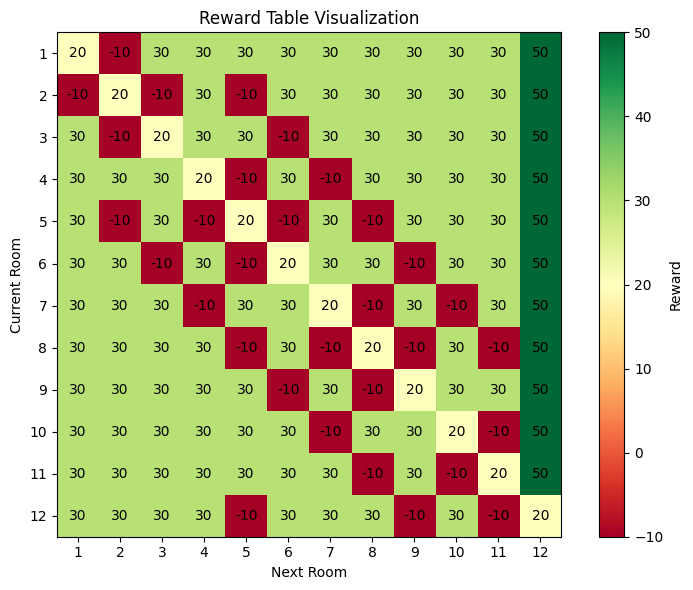

In [29]:
import numpy as np

# Initial reward table (from Question 2a, assumed to be all zeros - creating it for completeness)
reward_table = {}
for i in range(1, 13):
    for j in range(1, 13):
        reward_table[(i, j)] = 0

# Function to update reward table based on warehouse layout and rules
def update_reward_table(reward_table):

    # Define blocked paths (walls) - based on visual inspection of Figure 1
    blocked_paths = [
        (1, 2), (2, 1),
        (2, 3), (3, 2),
        (2, 5), (5, 2),
        (3, 6), (6, 3),
        (4, 5), (5, 4),
        (5, 6), (6, 5),
        (4, 7), (7, 4),
        (5, 8), (8, 5),
        (5, 12), (12, 5),
        (6, 9), (9, 6),
        (7, 8), (8, 7),
        (8, 9), (9, 8),
        (7, 10), (10, 7),
        (8, 11), (11, 8),
        (9, 12), (12, 9),
        (10, 11), (11, 10),
        (11, 12), (12, 11)
    ]

    # Define valid transitions (no walls)
    valid_transitions = []
    for i in range(1, 13):
      for j in range(1,13):
        if i != j and (i,j) not in blocked_paths:
          valid_transitions.append((i,j))

    # Apply rewards based on the rules
    for i in range(1, 13):
        for j in range(1, 13):
            if i == j:
                reward_table[(i, j)] = 20  # Invalid transition (same room)
            elif j == 12:
                reward_table[(i, j)] = 50  # Goal state
            elif (i, j) in blocked_paths:
                reward_table[(i, j)] = -10 # Blocked path
            elif (i,j) in valid_transitions:
                reward_table[(i,j)] = 30
            else:
                reward_table[(i, j)] = 0  # Default case (shouldn't happen with proper logic)

    return reward_table

# Update the reward table
reward_table = update_reward_table(reward_table)

# Print the updated reward table (for verification)
print("Updated Reward Table:")
for (start, end), reward in reward_table.items():
    print(f"({start}, {end}): {reward}")


# Visualization -  Adjacency Matrix Heatmap

# Create an adjacency matrix from the reward table
adjacency_matrix = np.zeros((12, 12))
for (start, end), reward in reward_table.items():
    adjacency_matrix[start-1, end-1] = reward  # Adjust indices to 0-11

# Visualize the adjacency matrix as a heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(adjacency_matrix, cmap='RdYlGn', interpolation='nearest')
plt.title('Reward Table Visualization')
plt.xlabel('Next Room')
plt.ylabel('Current Room')
plt.colorbar(label='Reward')
plt.xticks(range(12), [f'{i+1}' for i in range(12)])
plt.yticks(range(12), [f'{i+1}' for i in range(12)])

for i in range(12):
    for j in range(12):
        plt.text(j, i, int(adjacency_matrix[i, j]), ha="center", va="center", color="black")


plt.tight_layout()
plt.show()